# Mouse line analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from substitutors import *
from filters import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
mouseline = DEFAULT_LINE # Mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
baseline_wlen = BASELINE_WLEN  # length of rolling window for baseline computation
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile in folling window for baseline evaluation
baseline_smoothing = BASELINE_SMOOTHING   # whether to smooth the baseline with an extra moving average
ykey_postpro = Label.ZSCORE  # variable of interest for post-processing

### Derived parameters

In [4]:
dataroot = get_data_root()
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')
trialavg_root = get_output_equivalent(dataroot, 'raw', 'trial-averaged')
# Construct dataset group ID
dataset_group_id = mouseline
if layer is not None:
    dataset_group_id = f'{dataset_group_id}_{layer}'
# Construct post-processing ID
if baseline_wlen is None:
    baseline_smoothing = False
    baseline_id = ''
else:
    baseline_id = f'w{baseline_wlen:.1f}s'
baseline_id = f'{baseline_id}_q{baseline_quantile:.2f}'
if baseline_smoothing:
    baseline_id = f'{baseline_id}_smooth'
postpro_id = f'{baseline_id}_{ykey_postpro}'.replace('/', '')
figs_suffix = f'{dataset_group_id}_k{kalman_gain}_{postpro_id}'
submap = [(1, 0), (FrameIndex.STIM - 1, FrameIndex.STIM)]
ss = StackSubstitutor(submap, repeat_every=NFRAMES_PER_TRIAL)
kd = KalmanDenoiser(kalman_gain) if kalman_gain > 0 else NoFilter
trialavg_dir = os.path.join(trialavg_root, baseline_id, kd.code, ss.code, mouseline)

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} batch notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 31/05/2022 15:08:01: line3 batch notebook started on 2022-05-31 at 15:08:01


### Input summary table figure

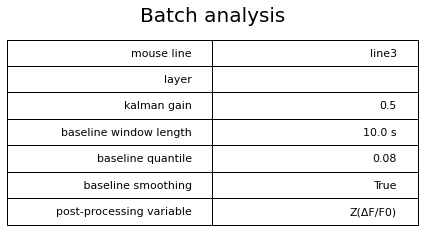

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'baseline window length': f'{baseline_wlen:.1f} s',
    'baseline quantile': baseline_quantile,
    ' baseline smoothing': baseline_smoothing,
    'post-processing variable': ykey_postpro
    }, title='Batch analysis')

### Load data

In [6]:
logger.info(f'loading data from {trialavg_dir}:')
data = load_processed_datasets(trialavg_dir, exclude_patterns=['2021', 'layer5'])
timeseries, stats = data['timeseries'], data['stats']

 31/05/2022 15:08:01: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/w10.0s_q0.08_smooth/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/line3:
 31/05/2022 15:08:01: excluding datasets with the following patterns: ['2021', 'layer5']
 31/05/2022 15:08:01: loading timeseries data from timeseries_20191107_mouse1_region1.csv
 31/05/2022 15:08:02: loading timeseries data from timeseries_20191107_mouse1_region2.csv
 31/05/2022 15:08:02: loading timeseries data from timeseries_20191108_mouse6_region1.csv
 31/05/2022 15:08:03: loading timeseries data from timeseries_20191108_mouse6_region2.csv
 31/05/2022 15:08:04: loading timeseries data from timeseries_20191109_mouse7_region1.csv
 31/05/2022 15:08:05: loading timeseries data from timeseries_20191109_mouse7_region2.csv
 31/05/2022 15:08:06: loading timeseries data from timeseries_20191110_mouse10_region1.csv
 31/05/2022 15:08:07: loading timeseries data from timeseries_20191112_mouse12_region1.csv
 31/05/2022 15:08:07: lo

### Breakdown per mouse region

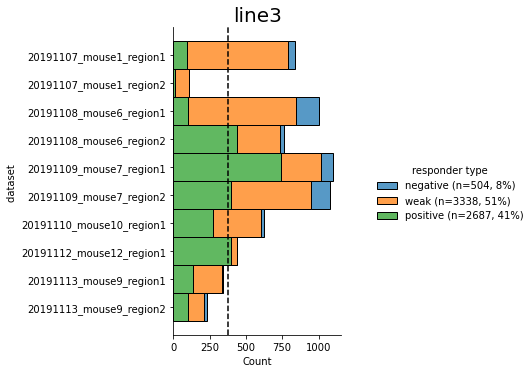

In [7]:
# Compute cell count threshold
um_per_px = 1.96  # from Bruker microscope
npx_per_line = 256  # from Bruker miscroscope
area = (um_per_px * npx_per_line)**2 / 1e6  # mm2
min_cell_count = MIN_CELL_DENSITY * area
# Plot breakdown
figs['rtype dist per mousereg'] = plot_cellcounts_by_type(
    stats, hue=Label.ROI_RESP_TYPE, min_cell_count=min_cell_count,
    title=mouseline)

### Exclude datasets with low cell count

In [8]:
# Idendify datasets with a low overall cell count
celltypes = stats.groupby([Label.DATASET, Label.ROI]).first()
cellcounts = celltypes.groupby(Label.DATASET).count().iloc[:, 0].rename('counts')
to_exclude = cellcounts.loc[cellcounts < min_cell_count].index.values.tolist()

# Exclude them
data = exclude_datasets(data.copy(), to_exclude)
timeseries = data['timeseries']
stats = data['stats']

 31/05/2022 15:08:35: excluding ['20191113_mouse9_region2', '20191113_mouse9_region1', '20191107_mouse1_region2'] datasets from analysis


### Parameter dependency curves

 31/05/2022 15:08:35: sub-indexing data...
 31/05/2022 15:08:35: filtering data...
 31/05/2022 15:08:35: cross-checking filters...
 31/05/2022 15:08:35: grouping by responder type, grouping by dataset, averaging and plotting mean diff Z(ΔF/F0) vs. P (MPa) ...
 31/05/2022 15:08:36: sub-indexing data...
 31/05/2022 15:08:36: filtering data...
 31/05/2022 15:08:36: cross-checking filters...
 31/05/2022 15:08:36: grouping by responder type, grouping by dataset, averaging and plotting mean diff Z(ΔF/F0) vs. DC (%) ...


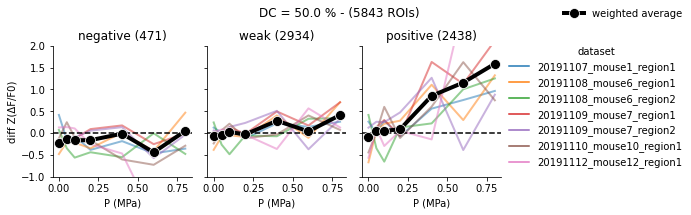

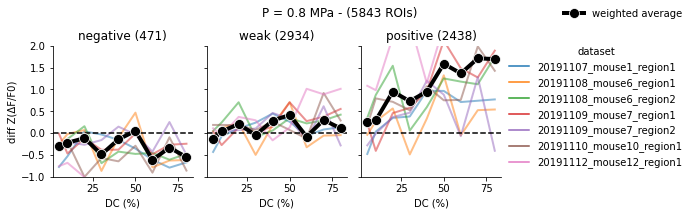

In [9]:
for pkey in [Label.P, Label.DC]:
    figs[f'{pkey}-dep {ykey_postpro}'] = plot_parameter_dependency_across_datasets(
        stats, pkey, Label.ZSCORE)

### Get plot-ready traces dataset

In [14]:
plt_data = get_plot_data(timeseries, stats)

 31/05/2022 14:01:50: merging timeseries and stats information...
 31/05/2022 14:02:30: adding time info to table...


### Pressure-dependent response traces

 28/05/2022 21:06:41: plotting P (MPa) dependency curves for negative responders...
 28/05/2022 21:06:42: sub-indexing data...
 28/05/2022 21:06:42: filtering data...
 28/05/2022 21:06:42: cross-checking filters...
 28/05/2022 21:06:42: grouping by dataset, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 28/05/2022 21:06:47: plotting P (MPa) dependency curves for positive responders...
 28/05/2022 21:06:48: sub-indexing data...
 28/05/2022 21:06:49: filtering data...
 28/05/2022 21:06:50: cross-checking filters...
 28/05/2022 21:06:51: grouping by dataset, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 28/05/2022 21:07:10: plotting P (MPa) dependency curves for weak responders...
 28/05/2022 21:07:12: sub-indexing data...
 28/05/2022 21:07:14: filtering data...
 28/05/2022 21:07:16: cross-checking filters...
 28/05/2022 21:07:17: grouping by dataset, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


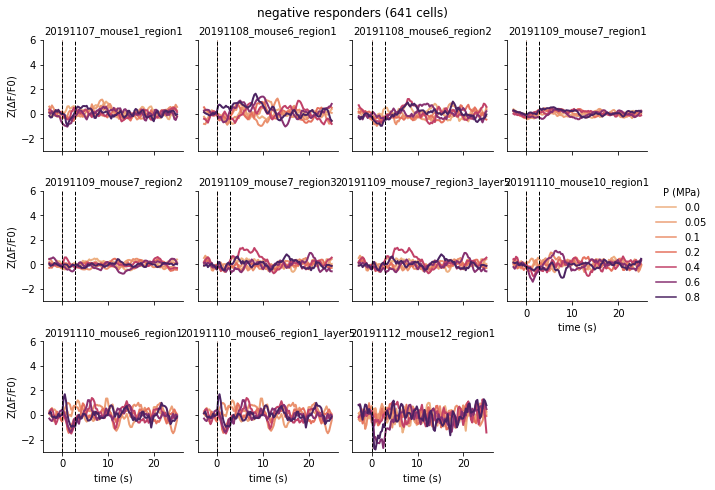

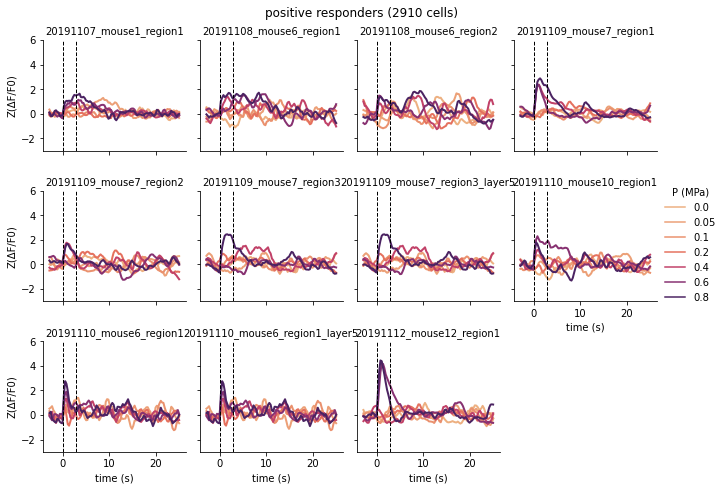

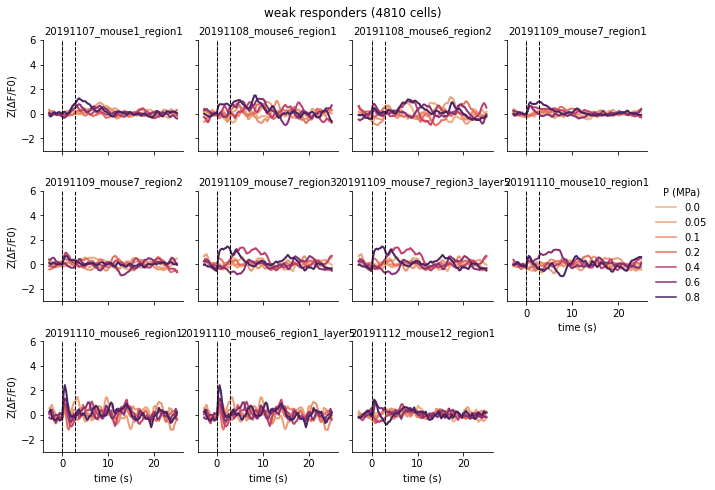

In [11]:
figs.update(
    plot_responses_across_datasets(plt_data, ykey=ykey_postpro, pkey=Label.P))

### DC-dependent response traces

 28/05/2022 21:07:53: plotting DC (%) dependency curves for negative responders...
 28/05/2022 21:07:53: sub-indexing data...
 28/05/2022 21:07:53: filtering data...
 28/05/2022 21:07:53: cross-checking filters...
 28/05/2022 21:07:53: grouping by dataset, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 28/05/2022 21:07:59: plotting DC (%) dependency curves for positive responders...
 28/05/2022 21:08:00: sub-indexing data...
 28/05/2022 21:08:01: filtering data...
 28/05/2022 21:08:02: cross-checking filters...
 28/05/2022 21:08:03: grouping by dataset, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 28/05/2022 21:08:27: plotting DC (%) dependency curves for weak responders...
 28/05/2022 21:08:29: sub-indexing data...
 28/05/2022 21:08:32: filtering data...
 28/05/2022 21:08:33: cross-checking filters...
 28/05/2022 21:08:36: grouping by dataset, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


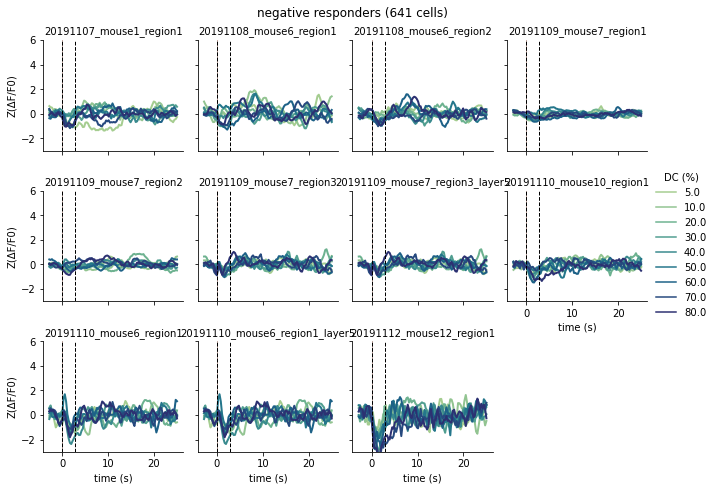

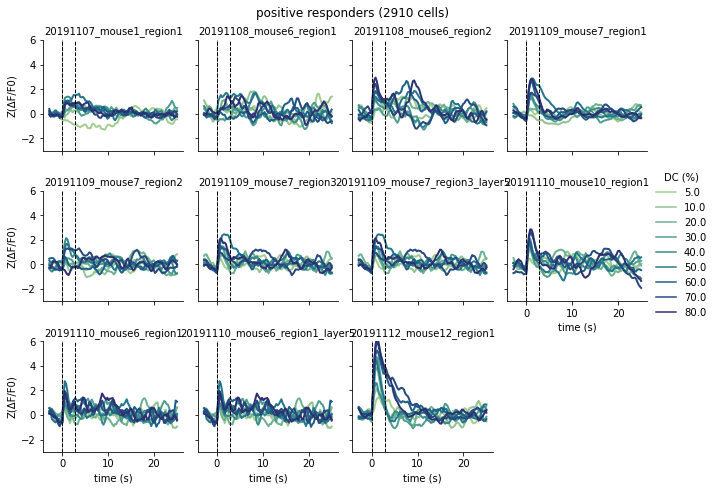

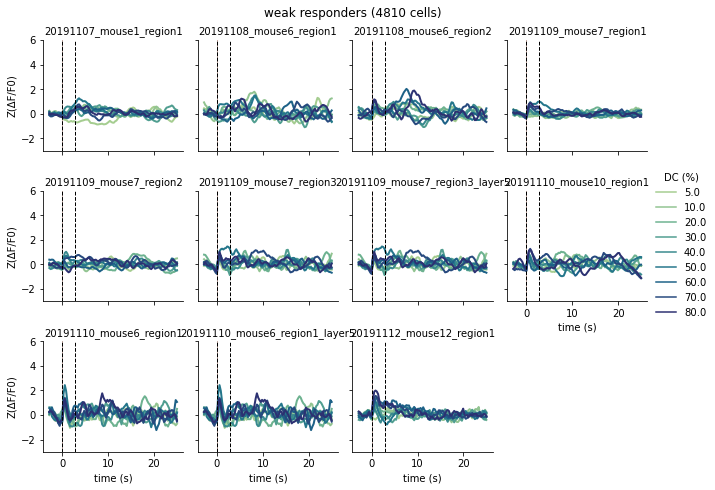

In [12]:
figs.update(
    plot_responses_across_datasets(plt_data, ykey=ykey_postpro, pkey=Label.DC))

### Average response traces across datasets (weighted)

 28/05/2022 21:09:15: sub-indexing data...
 28/05/2022 21:09:21: filtering data...
 28/05/2022 21:09:23: cross-checking filters...
 28/05/2022 21:09:26: grouping by responder type, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 28/05/2022 21:10:05: sub-indexing data...
 28/05/2022 21:10:09: filtering data...
 28/05/2022 21:10:12: cross-checking filters...
 28/05/2022 21:10:16: grouping by responder type, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


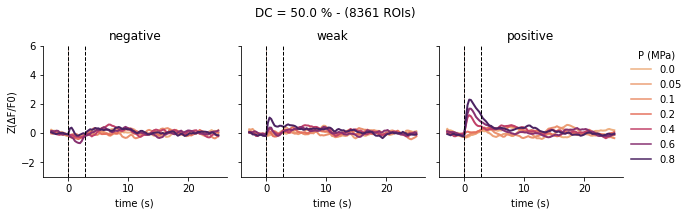

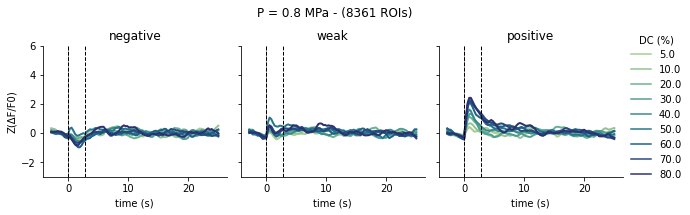

In [13]:
# Plot response curves for both input stimulation parameters  
for pkey in [Label.P, Label.DC]:
    figs[f'{ykey_postpro} vs. {pkey} by type - weighted'] = plot_responses_across_datasets(
        plt_data, ykey=ykey_postpro, pkey=pkey, avg=True)

### Average response traces across datasets (non-weighted)

 28/05/2022 21:11:08: checking for run order consistency across datasets...
 28/05/2022 21:11:12: variation in run orders across dataset
 28/05/2022 21:11:12: variation in run orders across dataset
 28/05/2022 21:11:12: computing average traces per dataset and condition...
 28/05/2022 21:11:20: sub-indexing data...
 28/05/2022 21:11:20: filtering data...
 28/05/2022 21:11:20: cross-checking filters...
 28/05/2022 21:11:20: grouping by responder type, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 28/05/2022 21:11:20: sub-indexing data...
 28/05/2022 21:11:20: filtering data...
 28/05/2022 21:11:20: cross-checking filters...
 28/05/2022 21:11:20: grouping by responder type, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


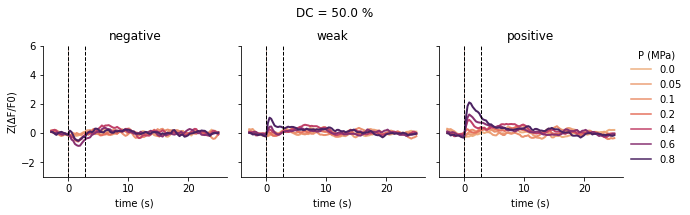

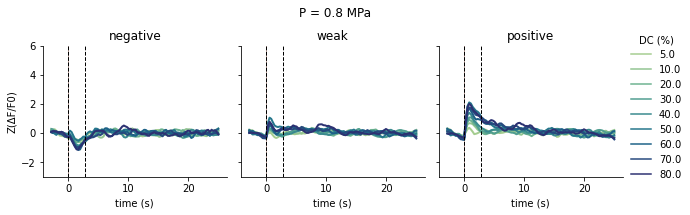

In [14]:
# Check run order consistency across datasets
logger.info('checking for run order consistency across datasets...')
params_per_run = plt_data.groupby([Label.DATASET, Label.RUN]).first()[[Label.P, Label.DC]]
for k in params_per_run:
    sum_of_stds = params_per_run[k].unstack().std().sum()
    if sum_of_stds > 1e-12:
        logger.error('variation in run orders across dataset')

# Group data by mouse-region, response type, run and frame -> average
logger.info('computing average traces per dataset and condition...')
avg_plt_data = plt_data.groupby(
    [Label.DATASET, Label.ROI_RESP_TYPE, Label.RUN, Label.FRAME]).mean()
avg_plt_data = resolve_columns(avg_plt_data, [Label.P, Label.DC, Label.DUR, Label.TIME])

# Plot response curves for both input stimulation parameters  
for pkey in [Label.P, Label.DC]:
    figs[f'{ykey_postpro} vs. {pkey} by type - nonweighted'] = plot_responses_across_datasets(
        avg_plt_data, ykey=ykey_postpro, pkey=pkey, avg=True)

### Save figures

In [15]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 28/05/2022 21:11:21: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.05.28/figs_line3_k0.5_w10.0s_q0.08_smooth_Z(ΔFF0).pdf:


100%|██████████| 14/14 [00:02<00:00,  5.09it/s]


### Notify upon completion

In [16]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 28/05/2022 21:11:23: line3 batch notebook completed in 0:06:47.579464 s
